In [1]:
import sys  
sys.path.insert(1, '/Users/simon/Documents/II/Dissertation/')
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from src.misc import load_processed_dataset, split_data

In [5]:
df = load_processed_dataset("aapl")

In [8]:
def standardize_column(df, column_name):
    """
    Standardize a column in a DataFrame and return the standardized column,
    along with the mean and standard deviation used for standardization.

    Parameters:
    - df: pandas.DataFrame containing the column to standardize.
    - column_name: string, the name of the column in df to be standardized.

    Returns:
    - A tuple containing:
        - A pandas.Series with the standardized values of the column.
        - The mean value used for standardization.
        - The standard deviation used for standardization.
    """
    mean_value = df[column_name].mean()
    std_value = df[column_name].std()
    standardized_column = (df[column_name] - mean_value) / std_value
    return standardized_column, mean_value, std_value


def denormalize_column(standardized_column, mean_value, std_value):
    """
    Denormalize a standardized column using specified mean and standard deviation.

    Parameters:
    - standardized_column: pandas.Series, the column to denormalize.
    - mean_value: float, the mean value used for the original standardization.
    - std_value: float, the standard deviation used for the original standardization.

    Returns:
    - A pandas.Series containing the denormalized values of the column.
    """
    denormalized_column = (standardized_column * std_value) + mean_value
    return denormalized_column

In [9]:
def plot_train_val_test(train, val, test, column_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        train.index, train[column_name], label="Training Set", color="blue", linewidth=2
    )
    ax.plot(
        val.index, val[column_name], label="Validation Set", color="green", linewidth=2
    )
    ax.plot(test.index, test[column_name], label="Test Set", color="red", linewidth=2)

    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel(column_name, fontsize=14)

    ax.legend()
    ax.grid(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.show()

In [63]:
def plot_column(df, column_name):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(df.index, df[column_name], color="blue", linewidth=0.5)
    ax.set_xlabel("Date", fontsize=10)
    ax.set_ylabel(column_name, fontsize=10)
    ax.grid(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.show()

# Transformer

In [186]:
df = load_processed_dataset("aapl")
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Close Forecast', 'close_t-1', 'close_t-2', 'close_t-3', 'close_t-4',
       'close_t-5', 'pct_change', 'return', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'upper_band',
       'middle_band', 'lower_band', 'SMA_3', 'SMA_5', 'SMA_10', 'SMA_20',
       'SMA_50', 'EMA_3', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'ADX',
       'aroon_down', 'aroon_up', 'macd', 'macdsignal', 'macdhist', 'RSI_14',
       'slow_k', 'slow_d', 'williams_r', 'AD', 'OBV', 'NATR', 'TRANGE',
       'fed_funds_rate', '^N225', '^IXIC', '^FTSE', '^SPX', '^DJI'],
      dtype='object')

In [93]:
# Define model parameters
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'pct_change', 'return', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'upper_band',
       'middle_band', 'lower_band', 'SMA_3', 'SMA_5', 'SMA_10', 'SMA_20',
       'SMA_50', 'EMA_3', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'ADX',
       'aroon_down', 'aroon_up', 'macd', 'macdsignal', 'macdhist', 'RSI_14',
       'slow_k', 'slow_d', 'williams_r', 'AD', 'OBV', 'NATR', 'TRANGE',
       'fed_funds_rate', '^N225', '^IXIC', '^FTSE', '^SPX', '^DJI']
n_features = len(features)  # Size of the input features
num_layers = 6  # Number of transformer layers
dropout = 0.1  # Dropout rate
sequence_len = 10

In [94]:
from src.models.Transformer.data import load_data

X, y = load_data(features, 10)
X.shape, y.shape

((1250, 10, 48), (1250, 10, 1))

In [156]:
X_train, X_val, X_test = split_data(X, verbose=True)
y_train, y_val, y_test = split_data(y, verbose=False)


Original data length: 1250
Train set length: 1000
Validation set length: 125
Test set length: 125
(1000, 10, 48) (125, 10, 48) (125, 10, 48)


In [161]:
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

#    (n_samples, sequence_len, n_features)
# -> (n_samples * sequence_len, n_features)

## NORMALISE
X_train = X_train.reshape(-1, X.shape[2])
X_test = X_test.reshape(-1, X.shape[2])
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

X_train = X_train.reshape(-1, sequence_len, n_features)
X_test = X_test.reshape(-1, sequence_len, n_features)
y_train = y_train.reshape(-1, sequence_len, 1)
y_test = y_test.reshape(-1, sequence_len, 1)

##

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [172]:
from src.models.Transformer.model import TimeSeriesTransformer
import torch.nn as nn
from torch.optim import Adam

# Instantiate the model
model = TimeSeriesTransformer(feature_size=n_features, num_layers=num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [182]:
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        for X, y in train_loader:
            optimizer.zero_grad()
            preds = model(X)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Train the model
train(model, train_loader, criterion, optimizer, epochs=30)

Epoch 1, Loss: 0.02676374651491642
Epoch 2, Loss: 0.03350716084241867
Epoch 3, Loss: 0.02179678902029991
Epoch 4, Loss: 0.0223909392952919
Epoch 5, Loss: 0.020161541178822517
Epoch 6, Loss: 0.014149841852486134
Epoch 7, Loss: 0.02635493315756321
Epoch 8, Loss: 0.02920268289744854
Epoch 9, Loss: 0.01710389368236065
Epoch 10, Loss: 0.01648920215666294
Epoch 11, Loss: 0.013598165474832058
Epoch 12, Loss: 0.014747601002454758
Epoch 13, Loss: 0.014195937663316727
Epoch 14, Loss: 0.024037498980760574
Epoch 15, Loss: 0.011872186325490475
Epoch 16, Loss: 0.014302846975624561
Epoch 17, Loss: 0.016720615327358246
Epoch 18, Loss: 0.01289581973105669
Epoch 19, Loss: 0.01159012783318758
Epoch 20, Loss: 0.014374957419931889
Epoch 21, Loss: 0.011642329394817352
Epoch 22, Loss: 0.011751838959753513
Epoch 23, Loss: 0.011747959069907665
Epoch 24, Loss: 0.014803299680352211
Epoch 25, Loss: 0.009559771046042442
Epoch 26, Loss: 0.013697692193090916
Epoch 27, Loss: 0.008819974958896637
Epoch 28, Loss: 0.007

R^2: -2.0349864020205937
MSE: 349.5757
RMSE: 18.696943
MAE: 16.887728
MAPE: 11.502984911203384


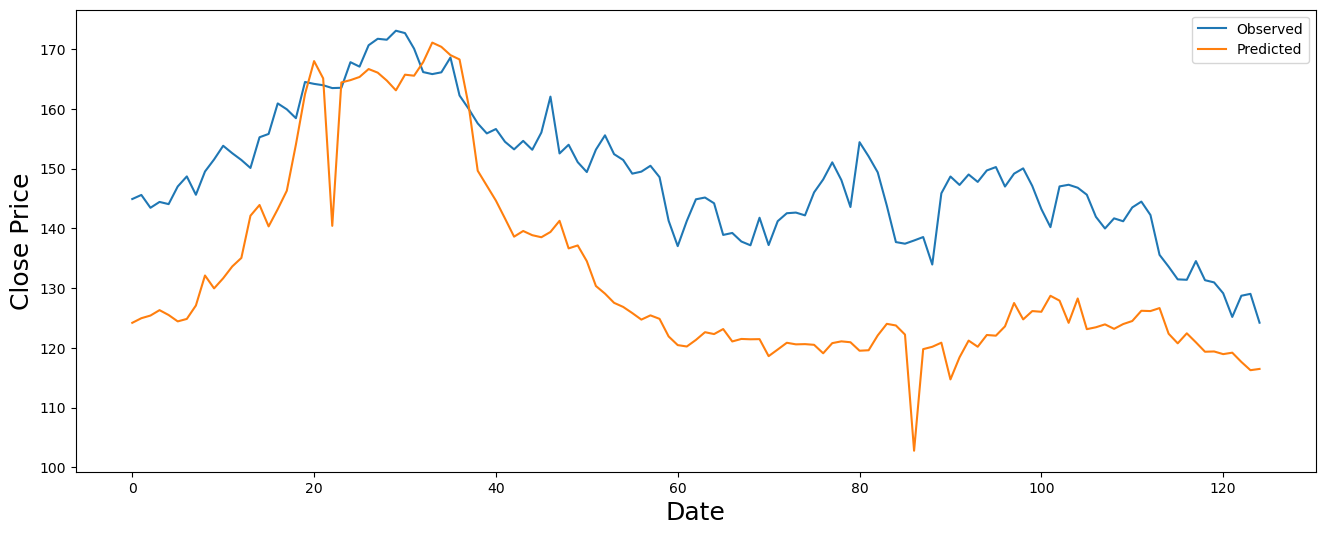

In [185]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from src.misc import evaluate, plot

def predict(model, test_loader):
    actuals, predictions = [], []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No gradients needed
        for X, y in test_loader:
            preds = model(X)
            preds = preds[:, -1:, :].squeeze()
            y = y[:, -1:, :].squeeze()
            actuals.extend(y)
            predictions.extend(preds)
    actuals = y_scaler.inverse_transform(np.array(actuals).reshape(-1,1))
    predictions = y_scaler.inverse_transform(np.array(predictions).reshape(-1,1))
    return predictions, actuals

# Evaluate the model
y_pred, y_true = predict(model, test_loader)

r2, mse, rmse, mae, mape = evaluate(y_pred, y_true, True)
plot(y_pred, y_true)

# Positional Encoder

In [121]:
import torch
import torch.nn as nn
import math


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        print(x.shape, self.pe.shape)
        return x + self.pe[: x.size(0), :]

# Transformer Model

In [122]:
class TransAm(nn.Module):
    def __init__(self, feature_size, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = "Transformer"

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_size, nhead=10, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers=num_layers
        )
        self.decoder = nn.Linear(feature_size, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

In [123]:
from src.misc import create_sequences, load_processed_dataset, split_data
import numpy as np
import pandas as pd


def load_data():
    """
    Returns X and y
    """
    df = load_processed_dataset("aapl", "2018-01-01", "2023-01-1")
    features = ["Open", "High", "Low", "Close", "Volume"]
    X = df[features]
    y = pd.DataFrame(df["Close Forecast"])

    sequence_length = 128
    X_seq = []
    y_seq = []
    for i in range(sequence_length, len(X) + 1):
        X_seq.append(X[i - sequence_length : i])
        y_seq.append(y[i - sequence_length : i])
    return np.array(X_seq), np.array(y_seq)

In [124]:
X, y = load_data()
X.shape, y.shape

((1132, 128, 5), (1132, 128, 1))

In [125]:
from torch.utils.data import TensorDataset, DataLoader

X_train, X_val, X_test = split_data(X, verbose=True)
y_train, y_val, y_test = split_data(y)

# TensorDatasets and DataLoaders
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Original data length: 1132
Train set length: 905
Validation set length: 113
Test set length: 114
(905, 128, 5) (113, 128, 5) (114, 128, 5)


In [ ]:
import torch
import torch.nn as nn

drop_prob = 0.1


class transformer_block(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(transformer_block, self).__init__()
        self.attention = nn.MultiheadAttention(
            embed_size, num_heads, batch_first=True
        )  # attention
        self.fc = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),  # fully connected
            nn.LeakyReLU(),
            nn.Linear(4 * embed_size, embed_size),
        )
        self.dropout = nn.Dropout(drop_prob)  # dropout
        self.ln1 = nn.LayerNorm(embed_size, eps=1e-6)  # norm
        self.ln2 = nn.LayerNorm(embed_size, eps=1e-6)  # norm

    def forward(self, x):
        attn_out, _ = self.attention(x, x, x, need_weights=False)
        x = x + self.dropout(attn_out)
        x = self.ln1(x)

        fc_out = self.fc(x)
        x = x + self.dropout(fc_out)
        x = self.ln2(x)

        return x


class transformer_forecaster(nn.Module):
    def __init__(self, embed_size, num_heads, num_blocks):
        super(transformer_forecaster, self).__init__()
        num_len = len(numeric_covariates)
        self.embedding_cov = nn.ModuleList(
            [
                nn.Embedding(n, embed_size - num_len)
                for n in categorical_covariates_num_embeddings
            ]
        )
        self.embedding_static = nn.ModuleList(
            [
                nn.Embedding(n, embed_size - num_len)
                for n in categorical_static_num_embeddings
            ]
        )

        self.blocks = nn.ModuleList(
            [transformer_block(embed_size, num_heads) for n in range(num_blocks)]
        )

        self.forecast_head = nn.Sequential(
            nn.Linear(embed_size, embed_size * 2),
            nn.LeakyReLU(),
            nn.Dropout(drop_prob),
            nn.Linear(embed_size * 2, embed_size * 4),
            nn.LeakyReLU(),
            nn.Linear(embed_size * 4, forecast_length),
            nn.ReLU(),
        )

    def forward(self, x_numeric, x_category, x_static):

        tmp_list = []
        for i, embed_layer in enumerate(self.embedding_static):
            tmp_list.append(embed_layer(x_static[:, i]))
        categroical_static_embeddings = torch.stack(tmp_list).mean(dim=0).unsqueeze(1)

        tmp_list = []
        for i, embed_layer in enumerate(self.embedding_cov):
            tmp_list.append(embed_layer(x_category[:, :, i]))
        categroical_covariates_embeddings = torch.stack(tmp_list).mean(dim=0)
        T = categroical_covariates_embeddings.shape[1]

        embed_out = (
            categroical_covariates_embeddings
            + categroical_static_embeddings.repeat(1, T, 1)
        ) / 2
        x = torch.concat((x_numeric, embed_out), dim=-1)

        for block in self.blocks:
            x = block(x)

        x = x.mean(dim=1)
        x = self.forecast_head(x)

        return x

In [126]:
import time 
def train():
    model.train() # Turn on the evaluation mode
    total_loss = 0.
    start_time = time.time()

    train_loss = 0.
    for Xs, ys in train_loader:
        optimizer.zero_grad()
        outputs = model(Xs)
        loss = criterion(outputs, ys) 
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= Xs.size(0)

In [128]:
model = TransAm(feature_size=6)
criterion = nn.MSELoss() # Loss function
lr = 0.00005 # learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
epochs =  5 # Number of epochs

AssertionError: embed_dim must be divisible by num_heads

In [115]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    
    if(epoch % epochs == 0): # Valid model after last training epoch
        val_loss = evaluate(model, val_data)
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch, (time.time() - epoch_start_time), val_loss))
        print('-' * 80)
    else:   
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
        print('-' * 80)

    scheduler.step() 

torch.Size([64, 128]) torch.Size([5000, 1, 250])


RuntimeError: The size of tensor a (128) must match the size of tensor b (250) at non-singleton dimension 2

# Time Embeddings

In [ ]:
# Time Embeddings

# Tutorial

In [ ]:
import torch
import torch.nn as nn

class SelfAttention(nn.Modeul):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads"
        
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)

        self.fc_out = nn.Linear(self.head_dim * heads, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split embedding into self.heads pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = values.reshape(N, key_len, self.heads, self.head_dim)
        queries = values.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, head_dim)
        # keys shape: (N, key_len, heads, head_dim)
        # energy shape: (N, heads, query_len, key_len) # for each word in target (query), how much focus on each word in input (key)

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))
        
        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads*self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # value shape: (N, value_len, heads, head_dim)
        # after einsum  (N, query_len, heads, head_dim) then flatten last two dimensions

        out = self.fc_out(out)
        return out 

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion*embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion*embed_size, embed_size)
        )
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))

class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
            for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expan(N, seq_length)

        out = self.dropout(self.word_embeddings(x) + self.position_embeddings(positions))

        for layer in self.layers:
            out = layer(out, out, out, mask)
        
        return out
    
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mas, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out

class Decoder(nn.Module):
    def __init__(self,
                 trg_vocab_size,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 dropout,
                 device,
                 max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
             for _ in range(num_layers)]
        )

        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length)
        x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)
        
        out = self.fc_out(x)
        return out

class Transformer(nn.Module):
    def __init__(
            self,
            src_vocab_size,
            trg_vocab_size,
            src_pad_idx,
            trg_pad_idx,
            embed_size=256,
            num_layers=6,
            forward_expansions=4,
            heads=8,
            dropout=0,
            device="cpu",
            max_length=1000
    ):
        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansions,
            dropout,
            max_length
        )

        self.encoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansions,
            dropout,
            device,
            max_length
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
    
    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # (N, 1, 1, src_len)
        return src_mask.to(self.device)
    
    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )
        return trg_mask.to(self.device)
    
    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out